Credit for this jupyter notebook: https://github.com/nerdimite/ntm/blob/master/Predict.ipynb, with minimal changes and visualizations by me.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys

sys.path.append('/content/gdrive/MyDrive/ML/projects/ntm')

In [ ]:
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset
from torch.distributions.binomial import Binomial
from torchvision import transforms as T

import json
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt

from bidirectional_ntm import NTM

In [ ]:
class CopyDataset(Dataset):
    """A Dataset class to generate random examples for the copy task. Each
    sequence has a random length between `min_seq_len` and `max_seq_len`.
    Each vector in the sequence has a fixed length of `seq_width`. The vectors
    are bounded by start and end delimiter flags.

    To account for the delimiter flags, the input sequence length as well
    width is two more than the target sequence.
    """

    def __init__(self, seq_width, min_seq_len, max_seq_len):
        '''Initialize a dataset instance for copy task.

        Args:
            task_params (dict): a dict containing parameters relevant to copy task.
        '''
        self.seq_width = seq_width
        self.min_seq_len = min_seq_len
        self.max_seq_len = max_seq_len

    def __len__(self):
        # sequences are generated randomly so this does not matter
        # set a sufficiently large size for data loader to sample mini-batches
        return 65536

    def __getitem__(self, idx):
        # Get sequence length
        seq_len = torch.randint(self.min_seq_len, self.max_seq_len, (1,), dtype=torch.long).item()
        # Generate sequences
        prob = 0.5 * torch.ones([seq_len, self.seq_width], dtype=torch.float64)
        seq = Binomial(1, prob).sample()

        # Fill in input sequence, two bit longer and wider than target
        input_seq = torch.zeros([seq_len + 2, self.seq_width + 2])
        input_seq[0, self.seq_width] = 1.0  # start delimiter
        input_seq[1:seq_len + 1, :self.seq_width] = seq
        input_seq[seq_len + 1, self.seq_width + 1] = 1.0  # end delimiter

        # Create target sequence
        target_seq = torch.zeros([seq_len, self.seq_width])
        target_seq[:seq_len, :self.seq_width] = seq

        return {'input': input_seq, 'target': target_seq}

In [ ]:
SEQ_WIDTH = 8
CONTROLLER_SIZE = 100
MEMORY_ROWS = 128
MEMORY_COLS = 20
NUM_HEADS = 1
SHIFT_DIM = 3
NUM_LAYERS = 2

MIN_SEQ_LEN = 1
MAX_SEQ_LEN = 20

NUM_STEPS = 20000
LOSS_STOP_TH = 0.001
ERROR_STOP_TH = 0.001

In [ ]:
ntm = NTM(input_dim = SEQ_WIDTH + 2,
          output_dim = SEQ_WIDTH,
          ctrl_dim = CONTROLLER_SIZE,
          memory_rows = MEMORY_ROWS,
          memory_cols = MEMORY_COLS,
          num_heads = NUM_HEADS,
          shift_dim = SHIFT_DIM,
          num_layers = NUM_LAYERS)

In [ ]:
dataset = CopyDataset(SEQ_WIDTH, MIN_SEQ_LEN, MAX_SEQ_LEN)

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.RMSprop(ntm.parameters(),
                          lr = 1e-4,
                          alpha = 0.95,
                          momentum = 0.9)

# optimizer = optim.Adam(ntm.parameters(),
#                           lr = 1e-4)

# scheduler = ExponentialLR(optimizer, gamma = 0.9)

## Train NTM model

In [ ]:
losses = []
errors = []

batch_losses = []
batch_errors = []

for step in tqdm(range(NUM_STEPS)):

    optimizer.zero_grad()
    ntm.reset()

    # Sample data
    data = dataset[step]
    inputs, target = data['input'], data['target']

    # Tensor to store outputs
    out = torch.zeros(target.size())

    # Process the inputs through NTM for memorization
    for i in range(inputs.size()[0]):
        # Forward passing all sequences for read
        ntm(inputs[i].unsqueeze(0))

    # Get the outputs from memory without real inputs
    zero_inputs = torch.zeros(inputs.size()[1]).unsqueeze(0) # dummy inputs
    for i in range(target.size()[0]):
        out[i] = ntm(zero_inputs)

    # Compute loss, backprop, and optimize
    loss = criterion(out, target)
    batch_losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_value_(ntm.parameters(), 1)
    optimizer.step()

    # Calculate binary outputs
    binary_output = out.clone()
    binary_output = binary_output.detach().apply_(lambda x: 0 if x < 0.5 else 1)

    # Sequence prediction error is calculted in bits per sequence
    error = torch.sum(torch.abs(binary_output - target))
    batch_errors.append(error.item())

    # Print Stats
    if step % 200 == 0:
        losses.extend(batch_losses)
        errors.extend(batch_errors)
        mean_loss = np.mean(batch_losses)
        mean_error = np.mean(batch_errors)
        print('Step {} == Loss {:.3f} == Error {} bits per sequence'.format(step, mean_loss, mean_error))
        batch_losses = []
        batch_errors = []

        if mean_loss < LOSS_STOP_TH and mean_error < ERROR_STOP_TH:
          torch.save(ntm.state_dict(), '/content/gdrive/MyDrive/ML/projects/ntm/model/ntm_copy_model.pt')
          break

  0%|          | 2/20000 [00:00<1:07:24,  4.94it/s]

Step 0 == Loss 0.689 == Error 6.0 bits per sequence


  1%|          | 201/20000 [00:42<54:45,  6.03it/s]

Step 200 == Loss 0.693 == Error 41.23 bits per sequence


  2%|▏         | 403/20000 [01:19<40:20,  8.10it/s]

Step 400 == Loss 0.693 == Error 41.48 bits per sequence


  3%|▎         | 602/20000 [01:55<50:07,  6.45it/s]

Step 600 == Loss 0.692 == Error 38.24 bits per sequence


  4%|▍         | 801/20000 [02:30<1:00:29,  5.29it/s]

Step 800 == Loss 0.706 == Error 36.495 bits per sequence


  5%|▌         | 1001/20000 [03:08<59:58,  5.28it/s] 

Step 1000 == Loss 0.673 == Error 33.885 bits per sequence


  6%|▌         | 1201/20000 [03:42<56:36,  5.53it/s]

Step 1200 == Loss 0.661 == Error 34.04 bits per sequence


  7%|▋         | 1401/20000 [04:18<53:46,  5.76it/s]

Step 1400 == Loss 0.647 == Error 32.04 bits per sequence


  8%|▊         | 1602/20000 [04:52<32:15,  9.50it/s]

Step 1600 == Loss 0.615 == Error 28.85 bits per sequence


  9%|▉         | 1802/20000 [05:26<33:14,  9.12it/s]

Step 1800 == Loss 0.562 == Error 25.12 bits per sequence


 10%|█         | 2001/20000 [06:00<1:03:47,  4.70it/s]

Step 2000 == Loss 0.487 == Error 20.655 bits per sequence


 11%|█         | 2203/20000 [06:36<43:20,  6.84it/s]

Step 2200 == Loss 0.472 == Error 21.805 bits per sequence


 12%|█▏        | 2402/20000 [07:07<38:59,  7.52it/s]

Step 2400 == Loss 0.325 == Error 11.295 bits per sequence


 13%|█▎        | 2601/20000 [07:41<49:38,  5.84it/s]

Step 2600 == Loss 0.097 == Error 1.53 bits per sequence


 14%|█▍        | 2800/20000 [08:15<49:34,  5.78it/s]

Step 2800 == Loss 0.066 == Error 1.415 bits per sequence


 15%|█▌        | 3001/20000 [08:51<1:02:20,  4.54it/s]

Step 3000 == Loss 0.064 == Error 1.43 bits per sequence


 16%|█▌        | 3202/20000 [09:27<43:53,  6.38it/s]

Step 3200 == Loss 0.002 == Error 0.005 bits per sequence


 17%|█▋        | 3403/20000 [10:07<37:40,  7.34it/s]

Step 3400 == Loss 0.039 == Error 0.405 bits per sequence


 18%|█▊        | 3600/20000 [10:45<49:00,  5.58it/s]

Step 3600 == Loss 0.000 == Error 0.0 bits per sequence


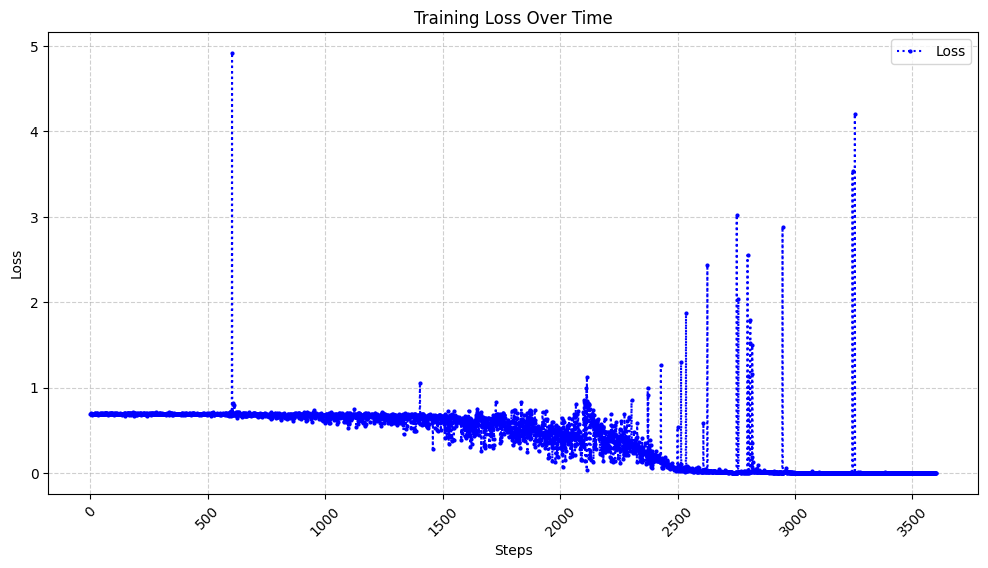

In [ ]:
xtick_inverval = 500

plt.figure(figsize=(12, 6))
plt.plot(losses, linestyle=':', color='b', marker='o', markersize=2, label='Loss')
plt.title('Training Loss Over Time')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.xticks(np.arange(0, len(losses), xtick_inverval), rotation = 45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

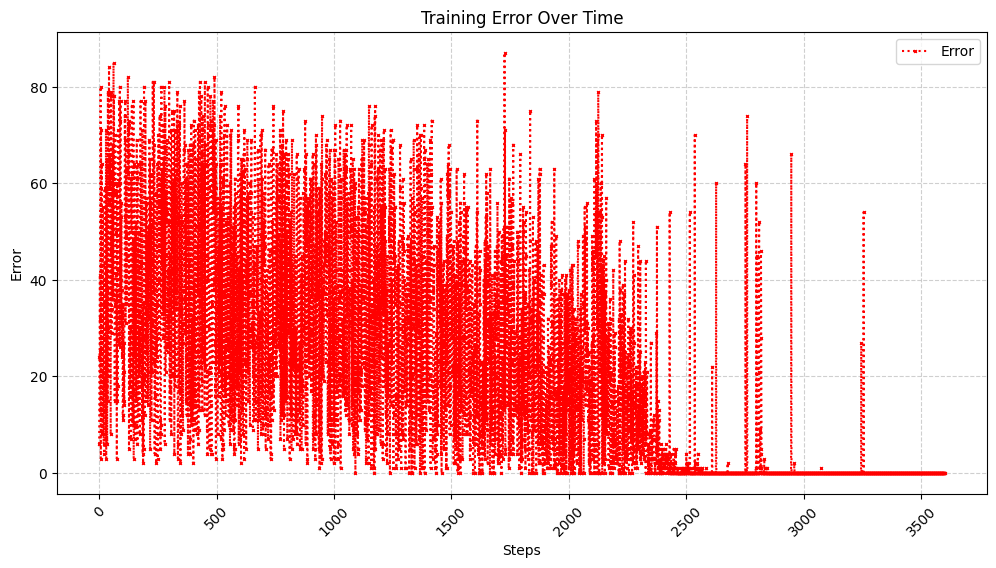

In [ ]:
xtick_inverval = 500

plt.figure(figsize=(12, 6))
plt.plot(errors, linestyle=':', color='r', marker='x', markersize=2, label='Error')
plt.title('Training Error Over Time')
plt.xlabel('Steps')
plt.ylabel('Error')
plt.xticks(np.arange(0, len(errors), xtick_inverval), rotation = 45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

## Test NTM model

In [ ]:
SEQ_WIDTH = 8
CONTROLLER_SIZE = 100
MEMORY_ROWS = 128
MEMORY_COLS = 20
NUM_HEADS = 1
SHIFT_DIM = 3
NUM_LAYERS = 2

In [ ]:
ntm = NTM(input_dim = SEQ_WIDTH + 2,
          output_dim = SEQ_WIDTH,
          ctrl_dim = CONTROLLER_SIZE,
          memory_rows = MEMORY_ROWS,
          memory_cols = MEMORY_COLS,
          num_heads = NUM_HEADS,
          shift_dim = SHIFT_DIM,
          num_layers = NUM_LAYERS)

In [ ]:
ntm.load_state_dict(torch.load('/content/gdrive/MyDrive/ML/projects/ntm/model/ntm_copy_model.pt'))

<All keys matched successfully>

In [ ]:
test_dataset = CopyDataset(SEQ_WIDTH, 60, 120)

In [ ]:
ntm.reset()

# Sample data
test_data = test_dataset[np.random.randint(65536)]
inputs, target = test_data['input'], test_data['target']

# Tensor to store outputs
out = torch.zeros(target.size())

# Process the inputs through NTM for memorization
for i in range(inputs.size()[0]):
    # Forward passing all sequences for read
    ntm(inputs[i].unsqueeze(0))

# Get the outputs from memory without real inputs
zero_inputs = torch.zeros(inputs.size()[1]).unsqueeze(0) # dummy inputs
for i in range(target.size()[0]):
    out[i] = ntm(zero_inputs)

# Calculate binary outputs
binary_output = out.clone()
binary_output = binary_output.detach().apply_(lambda x: 0 if x < 0.5 else 1)

# Sequence prediction error is calculted in bits per sequence
error = torch.sum(torch.abs(binary_output - target))
print(f'Error: {error} bits per sequence')

Error: 0.0 bits per sequence


In [ ]:
visualize = T.Compose([T.ToPILImage(), T.Resize(128, interpolation=0)])

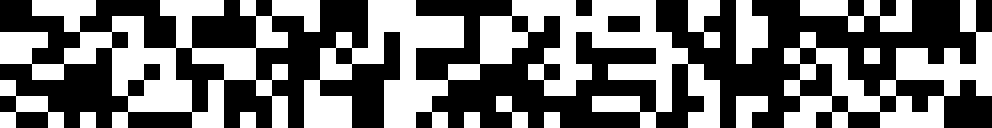

In [ ]:
visualize(target.permute(1, 0))

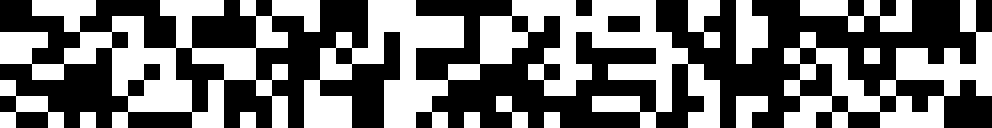

In [ ]:
visualize(binary_output.permute(1, 0))